In [1]:
import rasterio
import matplotlib.pyplot as plt
import numpy as np

from matplotlib.colors import ListedColormap


In [3]:
# Path to your GHS-BUILT-C file
file_path = r"GHS BUILT C\GHS_BUILT_C_FUN_E2018_GLOBE_R2023A_54009_10_V1_0_R5_C25.tif"

# Define chunk size
chunk_size = 1000  # Process 1000 x 1000 pixels at a time

# Initialize class counts dictionary
class_counts = {0: 0, 1: 0, 2: 0, 3: 0}

# Read raster metadata
with rasterio.open(file_path) as src:
    height, width = src.shape
    bounds = src.bounds

    # Initialize output array (for display, downsample if needed)
    smod_remapped = np.zeros((height, width), dtype=np.uint8)

    # Process in chunks
    for i in range(0, height, chunk_size):
        for j in range(0, width, chunk_size):
            window = rasterio.windows.Window(j, i, min(chunk_size, width - j), min(chunk_size, height - i))
            smod_chunk = src.read(1, window=window)
            
            # Remap smod values
            chunk_remapped = np.full_like(smod_chunk, 3, dtype=np.uint8)
            chunk_remapped[smod_chunk == 0] = 0
            chunk_remapped[smod_chunk == 1] = 1
            chunk_remapped[smod_chunk == 2] = 2
            
            # Store in output
            smod_remapped[i:i+window.height, j:j+window.width] = chunk_remapped
            
            # Calculate class distribution for this chunk
            unique, counts = np.unique(chunk_remapped, return_counts=True)
            for val, count in zip(unique, counts):
                class_counts[val] += count

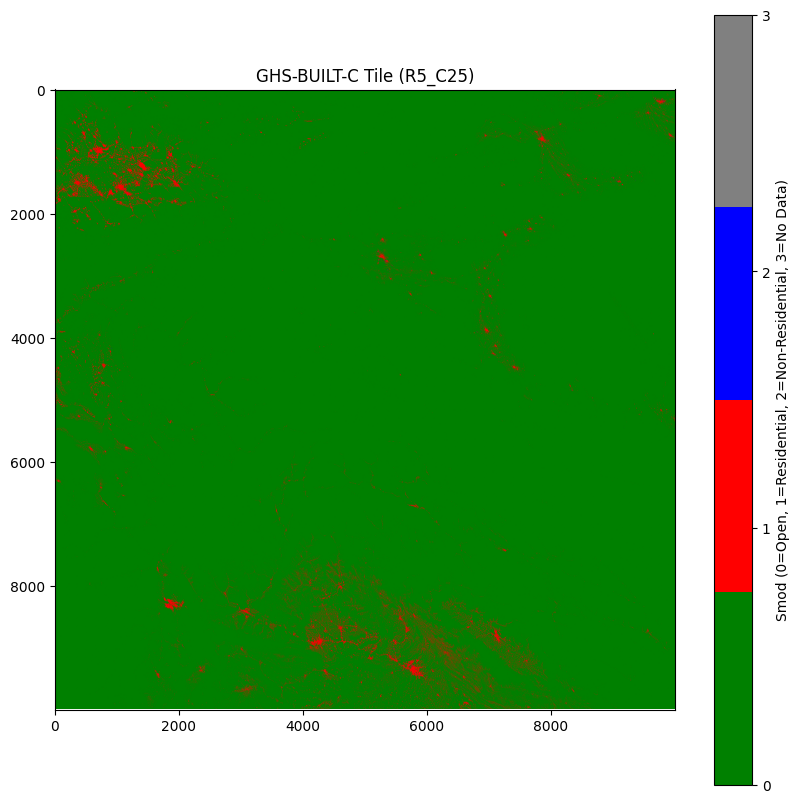

Class distribution: {0: np.int64(9817031141), 1: np.int64(182256585), 2: np.int64(712274), 3: 0}


In [4]:
# Define custom colormap
colors_list = ['green', 'red', 'blue', 'gray']
cmap_custom = ListedColormap(colors_list)

# Plot (downsample for display)
plt.figure(figsize=(10, 10))
plt.imshow(smod_remapped[::10, ::10], cmap=cmap_custom, vmin=0, vmax=3)
plt.colorbar(ticks=[0, 1, 2, 3], label='Smod (0=Open, 1=Residential, 2=Non-Residential, 3=No Data)')
plt.title('GHS-BUILT-C Tile (R5_C25)')
plt.show()

# Print class distribution
print("Class distribution:", class_counts)

In [48]:
import rasterio
from rasterio.windows import Window

input_path = "Sentinel2/GRANULE/L2A_T43SCT_A018349_20181227T055233/IMG_DATA/R10m/T43SCT_20181227T055231_TCI_10m.jp2"
output_path = "T43SCT_trimmed_bottom_left.jp2"

with rasterio.open(input_path) as src:
    width = src.width
    height = src.height

    # Step 1: bottom-left quarter
    quarter_width = width // 2
    quarter_height = height // 2
    quarter_window = Window(0, height // 2, quarter_width, quarter_height)

    # Step 2: further trim 1/3 from bottom and right
    final_width = int(quarter_width * (2/3))
    final_height = int(quarter_height * (2/3))

    # Define new window (origin remains same as bottom-left quarter)
    final_window = Window(0, height // 2, final_width, final_height)

    # Update profile
    profile = src.profile
    profile.update({
        "height": final_window.height,
        "width": final_window.width,
        "transform": rasterio.windows.transform(final_window, src.transform)
    })

    # Read and write cropped data
    with rasterio.open(output_path, "w", **profile) as dst:
        dst.write(src.read(window=final_window))


In [63]:
import os
import numpy as np
import rasterio
from rasterio.windows import from_bounds, Window
from rasterio.warp import transform_bounds, reproject, Resampling

# ─── 1) Paths ────────────────────────────────────────────────────────────────
sentinel_fp = r"D:\Ass\ANN\Attention\Sentinel2_cropped\T43SCT_trimmed_bottom_left.jp2"
ghs_fp      = r"D:\Ass\ANN\Attention\Cropped GHS BUILT C\cropped_ghs.tif"
out_fp      = r"D:\Ass\ANN\Attention\Cropped GHS BUILT C\ghs_matched_to_sentinel.tif"
os.makedirs(os.path.dirname(out_fp), exist_ok=True)

# ─── 2) Read Sentinel bounds + CRS/grid info ───────────────────────────────
with rasterio.open(sentinel_fp) as src_s:
    tci_crs       = src_s.crs
    tci_transform = src_s.transform
    tci_width     = src_s.width
    tci_height    = src_s.height
    tci_profile   = src_s.profile.copy()
    # spatial extent in Sentinel CRS
    tci_bounds    = src_s.bounds

# ─── 3) Compute those bounds in GHS (Mollweide) CRS ──────────────────────────
with rasterio.open(ghs_fp) as src_g:
    # transform the TCI bounding box into GHS CRS
    ghs_bounds = transform_bounds(tci_crs, src_g.crs,
                                  *tci_bounds,
                                  densify_pts=21)
    # window in GHS pixel/row‐col space
    win        = from_bounds(*ghs_bounds, transform=src_g.transform).round_offsets().round_lengths()

    # read only that window (all bands; GHS is single‐band anyway)
    ghs_chunk      = src_g.read(window=win)
    chunk_transform = src_g.window_transform(win)
    ghs_dtype      = src_g.dtypes[0]
    ghs_crs        = src_g.crs

# ─── 4) Prepare an output array matching the Sentinel grid ──────────────────
# single band, same shape as TCI
dst_array = np.zeros((tci_height, tci_width), dtype=ghs_dtype)

# ─── 5) Reproject the small GHS chunk into the Sentinel CRS/grid ──────────
reproject(
    source=ghs_chunk[0],           # our single band
    destination=dst_array,
    src_transform=chunk_transform,
    src_crs=ghs_crs,
    dst_transform=tci_transform,
    dst_crs=tci_crs,
    resampling=Resampling.nearest
)

# ─── 6) Write out a one‐band GeoTIFF aligned to Sentinel ────────────────────
tci_profile.update({
    "driver":    "GTiff",
    "count":     1,
    "dtype":     ghs_dtype,
    "compress":  "lzw",
    "width":     tci_width,
    "height":    tci_height,
    "transform": tci_transform,
    "crs":       tci_crs
})
with rasterio.open(out_fp, "w", **tci_profile) as dst:
    dst.write(dst_array, 1)

print("✅ Wrote aligned GHS to:", out_fp)


✅ Wrote aligned GHS to: D:\Ass\ANN\Attention\Cropped GHS BUILT C\ghs_matched_to_sentinel.tif


In [65]:
import os
import rasterio
from rasterio.windows import from_bounds
from rasterio.enums import Resampling
import shutil

# Base paths
reference_path = r"D:\Ass\ANN\Attention\T43SCT_trimmed_bottom_left.jp2"
sentinel_base = r"D:\Ass\ANN\Attention\Sentinel2"
output_base = r"D:\Ass\ANN\Attention\Sentinel2_cropped"

# Step 1: Read reference bounds and CRS
with rasterio.open(reference_path) as ref:
    ref_bounds = ref.bounds
    ref_crs = ref.crs

# Step 2: Walk through Sentinel2 folder and process all .jp2 bands
for dirpath, dirnames, filenames in os.walk(sentinel_base):
    for fname in filenames:
        if fname.lower().endswith('.jp2'):
            src_path = os.path.join(dirpath, fname)

            # Open the JP2 file and check CRS
            with rasterio.open(src_path) as src:
                if src.crs != ref_crs:
                    print(f"Skipping {src_path}: CRS mismatch.")
                    continue

                # Get window for cropping
                try:
                    window = from_bounds(*ref_bounds, transform=src.transform)
                    window = window.round_offsets().round_lengths()
                except Exception as e:
                    print(f"Could not compute window for {src_path}: {e}")
                    continue

                # Read and crop
                cropped = src.read(window=window)
                transform = src.window_transform(window)

                # Prepare destination path
                rel_path = os.path.relpath(src_path, sentinel_base)
                dst_path = os.path.join(output_base, rel_path)
                os.makedirs(os.path.dirname(dst_path), exist_ok=True)

                # Update profile
                profile = src.profile.copy()
                profile.update({
                    "height": cropped.shape[1],
                    "width": cropped.shape[2],
                    "transform": transform
                })

                # Write cropped image
                with rasterio.open(dst_path, 'w', **profile) as dst:
                    dst.write(cropped)

                print(f"✔ Saved cropped: {dst_path}")


✔ Saved cropped: D:\Ass\ANN\Attention\Sentinel2_cropped\GRANULE\L2A_T43SCT_A018349_20181227T055233\IMG_DATA\R10m\T43SCT_20181227T055231_AOT_10m.jp2
✔ Saved cropped: D:\Ass\ANN\Attention\Sentinel2_cropped\GRANULE\L2A_T43SCT_A018349_20181227T055233\IMG_DATA\R10m\T43SCT_20181227T055231_B02_10m.jp2
✔ Saved cropped: D:\Ass\ANN\Attention\Sentinel2_cropped\GRANULE\L2A_T43SCT_A018349_20181227T055233\IMG_DATA\R10m\T43SCT_20181227T055231_B03_10m.jp2
✔ Saved cropped: D:\Ass\ANN\Attention\Sentinel2_cropped\GRANULE\L2A_T43SCT_A018349_20181227T055233\IMG_DATA\R10m\T43SCT_20181227T055231_B04_10m.jp2
✔ Saved cropped: D:\Ass\ANN\Attention\Sentinel2_cropped\GRANULE\L2A_T43SCT_A018349_20181227T055233\IMG_DATA\R10m\T43SCT_20181227T055231_B08_10m.jp2
✔ Saved cropped: D:\Ass\ANN\Attention\Sentinel2_cropped\GRANULE\L2A_T43SCT_A018349_20181227T055233\IMG_DATA\R10m\T43SCT_20181227T055231_TCI_10m.jp2
✔ Saved cropped: D:\Ass\ANN\Attention\Sentinel2_cropped\GRANULE\L2A_T43SCT_A018349_20181227T055233\IMG_DATA\R10m